<a href="https://colab.research.google.com/github/Nurfaidah636/PCVK_Genap_2021/blob/main/BrainTumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


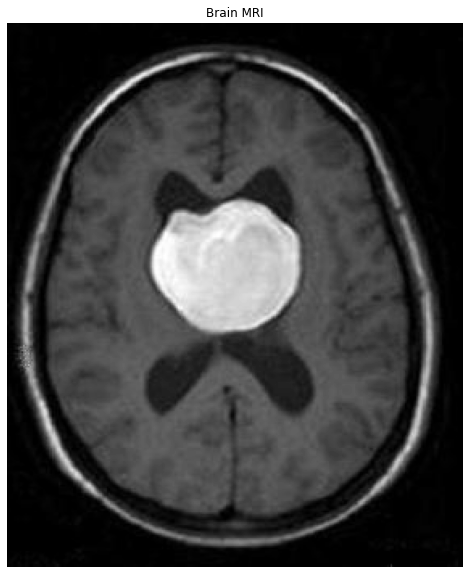

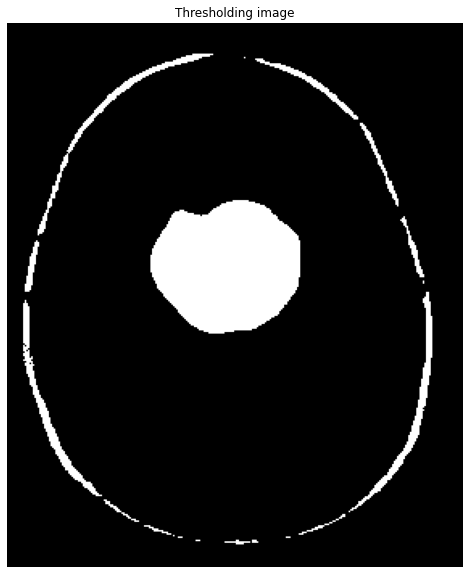

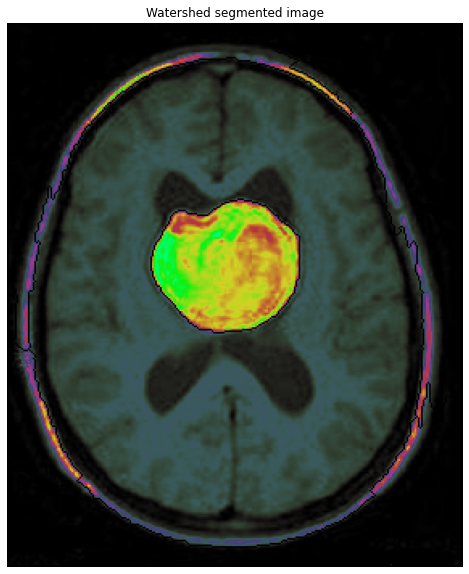

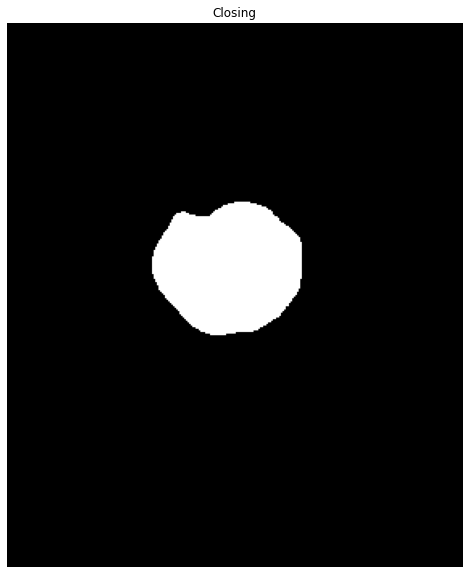

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.morphology import watershed as skwater

def ShowImage(title,img,ctype):
  plt.figure(figsize=(10, 10))
  if ctype=='bgr':
    b,g,r = cv2.split(img)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(rgb_img)
  elif ctype=='hsv':
    rgb = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    plt.imshow(rgb)
  elif ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.axis('off')
  plt.title(title)
  plt.show()
img           = cv2.imread('/content/drive/MyDrive/Polinema/Images/Y253.JPG')
gray          = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ShowImage('Brain MRI',gray,'gray')

ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)
ShowImage('Thresholding image',thresh,'gray')

ret, markers = cv2.connectedComponents(thresh)

#Get the area taken by each component. Ignore label 0 since this is the background.
marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 
#Get label of largest component by area
largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        
#Get pixels which correspond to the brain
brain_mask = markers==largest_component

brain_out = img.copy()
#In a copy of the original image, clear those pixels that don't correspond to the brain
brain_out[brain_mask==False] = (0,0,0)

img = cv2.imread('/content/drive/MyDrive/Polinema/Images/Y253.JPG')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
    
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
   
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
     
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

     
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

im1 = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
ShowImage('Watershed segmented image',im1,'gray')

brain_mask = np.uint8(brain_mask)
kernel = np.ones((8,8),np.uint8)
closing = cv2.morphologyEx(brain_mask, cv2.MORPH_CLOSE, kernel)
ShowImage('Closing', closing, 'gray')

brain_out = img.copy()
#In a copy of the original image, clear those pixels that don't correspond to the brain
brain_out[closing==False] = (0,0,0)